PDE 损失: 4.79e+01 | 边界损失: 2.18e+04 | 总损失: 2.18e+04: 100%|██████████| 10000/10000 [15:03<00:00, 11.07it/s]


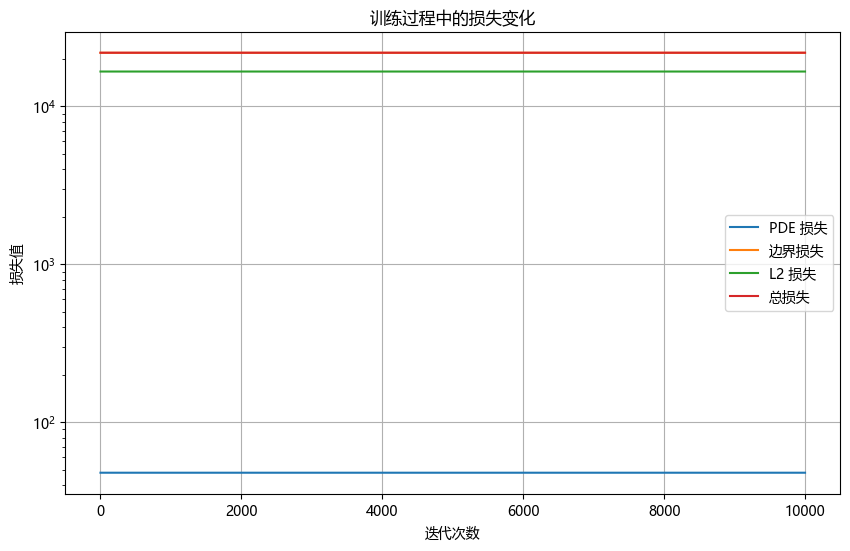

In [37]:
import torch
from torch import nn, optim, autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import LBFGS
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 定义维度和参数
dim = 2
np_i = 21  # 内部点数（每个维度）
ranges = [-1, 1]

# MLP 模型定义
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 100)  # 输入维度为2，隐藏层维度为50
        self.fc2 = nn.Linear(100,100)  # 隐藏层维度为50，输出维度为50
        self.fc3 = nn.Linear(100,1)  # 隐藏层维度为50，输出维度为1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化 MLP 模型
model = MLP()

def batch_jacobian(func, x, create_graph=False):
    # 计算批次雅可比矩阵的函数
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# 定义全局参数
A = 240  # 最大振幅
x0 = 50  # 波形中心位置（网格单位）
L = 5    # 波形沿x轴的尺度（网格单位）
B = 50   # 潮汐力振幅
C = 20   # 风应力系数
theta = np.pi / 4  # 风向与x轴的夹角（弧度）
D = 30  # 海洋流影响的系数
Y_deep = 4000  # 海洋深度（网格单位）

# 根据全局参数计算的值
kx = 2 * np.pi / L  # x方向的波数
ky = 1  # y方向的波数（假设）

# 定义解析解函数，只接受空间变量 x
sol_fun = lambda x: A * torch.sin(kx * (x[:, 0] - x0)) * torch.cos(ky * x[:, 1])

# 定义源项函数，只接受空间变量 x
source_fun = lambda x: B * torch.cos(kx * x[:, 0]) * torch.ones_like(x[:, 1]) + C * torch.sin(torch.tensor(theta)) * torch.cos(ky * x[:, 1]) +  D * torch.sin(2 * np.pi * x[:, 1] / Y_deep)

# 内部点采样模式 ('mesh' 或 'random')
sampling_mode = 'mesh'

x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    # 使用网格点作为内部点
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
else:
    # 在域内随机采样内部点
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

# 边界点（域的四条边）
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

# 训练参数
steps = 10000  # 优化步数
alpha = 0.5  # PDE 损失相对于边界损失的权重
log = 1  # 日志记录频率

# 用于存储训练过程中损失的列表
pde_losses = []
bc_losses = []
l2_losses = []
losses = []

def train():
    # 初始化 LBFGS 优化器
    optimizer = LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 进度条用于可视化训练进度
    pbar = tqdm(range(steps), desc='训练进度')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # 计算内部点的 PDE 损失
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            # pde_loss = torch.mean((lap - source) ** 2)
            delta = 1.0
            pde_loss = torch.mean(torch.where(torch.abs(lap - source) < delta, 0.5 * (lap - source)**2, delta * (torch.abs(lap - source) - 0.5 * delta)))

            # 计算边界损失
            bc_true = sol_fun(x_b)
            # bc_true = torch.cat([
            #    torch.sin(torch.pi * xb1[:, 1]).unsqueeze(1),
            #    torch.sin(torch.pi * xb2[:, 1]).unsqueeze(1),
            #    torch.sin(torch.pi * xb3[:, 0]).unsqueeze(1),
            #    torch.sin(torch.pi * xb4[:, 0]).unsqueeze(1)
            # ], dim=0)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true) ** 2)

            # 总损失
            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        # 执行优化步骤
        optimizer.step(closure)

        # 计算内部点的 L2 损失
        sol = sol_fun(x_i)
        l2 = torch.mean((model(x_i) - sol) ** 2)

        # 将损失值存入列表
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        l2_losses.append(l2.item())
        losses.append((alpha * pde_loss + bc_loss).item())

        # 更新进度条显示当前损失
        if _ % log == 0:
            pbar.set_description(f"PDE 损失: {pde_loss.item():.2e} | 边界损失: {bc_loss.item():.2e} | 总损失: {(alpha * pde_loss + bc_loss).item():.2e}")

    # 返回训练后的模型和损失数据
    return model, pde_losses, bc_losses, l2_losses, losses


# 开始训练模型并获取结果
trained_model, pde_losses, bc_losses, l2_losses, losses = train()

# 可视化预测解和解析解
with torch.no_grad():
    pred_solution = trained_model(x_i).reshape(np_i, np_i).cpu().numpy()
    exact_solution = sol_fun(x_i).reshape(np_i, np_i).cpu().numpy()

plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE 损失')
plt.plot(bc_losses, label='边界损失')
plt.plot(l2_losses, label='L2 损失')
plt.plot(losses, label='总损失')
plt.yscale('log')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.legend()
plt.title('训练过程中的损失变化')
plt.grid(True)
plt.show()

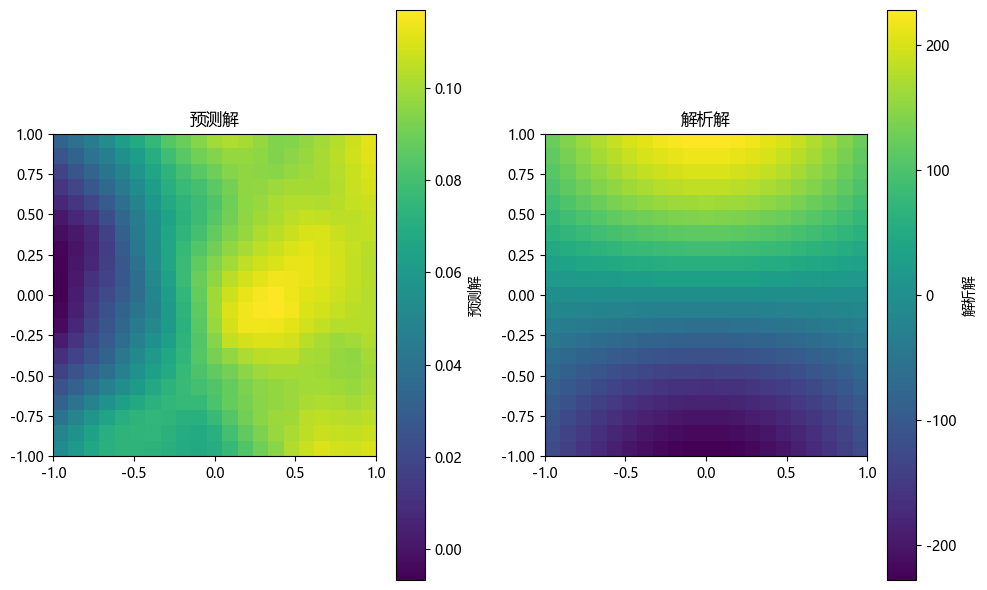

In [38]:
# 绘制预测解和解析解
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(pred_solution, extent=[ranges[0], ranges[1], ranges[0], ranges[1]], origin='lower')
plt.colorbar(label='预测解')
plt.title('预测解')

plt.subplot(1, 2, 2)
plt.imshow(exact_solution, extent=[ranges[0], ranges[1], ranges[0], ranges[1]], origin='lower')
plt.colorbar(label='解析解')
plt.title('解析解')

plt.tight_layout()
plt.show()

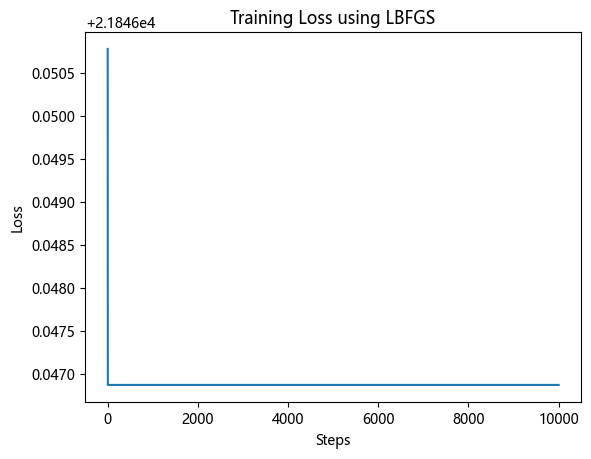

In [39]:
# 绘制损失
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss using LBFGS')
plt.show()

In [40]:
# 拟合预测解的多项式表达式
x_sample = x_i[:, 0].numpy()
y_sample = x_i[:, 1].numpy()
z_sample = pred_solution.flatten()

# 构建多项式特征
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(np.vstack((x_sample, y_sample)).T)

# 拟合多项式
lin_reg = LinearRegression()
lin_reg.fit(X_poly, z_sample)
coefficients = lin_reg.coef_
intercept = lin_reg.intercept_

# 打印多项式表达式
print("预测解的多项式拟合表达式:")
terms = poly.get_feature_names_out(['x', 'y'])
expression = f"{intercept:.4f}"
for coef, term in zip(coefficients[1:], terms[1:]):
    expression += f" + ({coef:.4f})*{term}"
print(f"u(x, y) ≈ {expression}")

预测解的多项式拟合表达式:
u(x, y) ≈ 0.0925 + (-0.0004)*x + (0.0800)*y + (-0.0158)*x^2 + (0.0134)*x y + (-0.0599)*y^2 + (0.0048)*x^3 + (-0.0825)*x^2 y + (-0.0319)*x y^2 + (-0.0367)*y^3 + (0.0102)*x^4 + (-0.0127)*x^3 y + (0.0432)*x^2 y^2 + (0.0046)*x y^3 + (0.0144)*y^4 + (0.0061)*x^5 + (0.0269)*x^4 y + (-0.0191)*x^3 y^2 + (0.0375)*x^2 y^3 + (0.0352)*x y^4 + (0.0123)*y^5
